In [2]:
import os
import re
import requests
import urllib
import numpy as np
from pandas import datetime
import pandas as pd
import geopandas as gpd
from pandas.tseries.holiday import USFederalHolidayCalendar as cal

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster

%matplotlib inline
plt.style.use('ggplot')

In [34]:
#download dataset from site (most updated dataset) - takes about 2m0s
url = "https://data.lacity.org/api/views/y8tr-7khq/rows.csv?accessType=DOWNLOAD"
urllib.request.urlretrieve(url, '/Users/nonoumasy/Dropbox/reference/data/LA_Crime_Data_from_2010_to_Present.csv')

('/Users/nonoumasy/Dropbox/reference/data/LA_Crime_Data_from_2010_to_Present.csv',
 <http.client.HTTPMessage at 0x1acfd7be10>)

In [3]:
#dataset as a flat file - 15.8s
df = pd.read_csv('/Users/nonoumasy/Dropbox/reference/data/LA_Crime_Data_from_2010_to_Present.csv')

In [5]:
#clean and prepare the data - 51.6s

#keep only relevant columns
df = df[['Date Occurred','Time Occurred','Area Name','Crime Code','Crime Code Description','MO Codes', 
         'Victim Age', 'Victim Sex','Victim Descent','Premise Description','Weapon Description',
         'Status Description','Crime Code 1', 'Address', 'Cross Street', 'Location ']]

#column cleanup
df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')

#change some columns to category type
for col in ['area_name', 'victim_sex', 'victim_descent', 'crime_code_description', 
            'premise_description', 'weapon_description', 'cross_street']:
    df[col] = df[col].astype('category')

#convert location column str to float
df.location_ = df.location_.astype(str).str.replace('(', '').str.replace(')', '').str.split(',').apply(lambda lst: [float(x.strip()) for x in lst])

#cleanup and process datatime data
df.time_occurred = df.time_occurred.astype(str)
df.time_occurred = df.time_occurred.str.zfill(4)
df.time_occurred = df.time_occurred.str.ljust(6, fillchar='0')
df.time_occurred = df.time_occurred.str.slice(0,2) + ':' + df.time_occurred.str.slice(2,4) + ":" + df.time_occurred.str.slice(4,6)

#combine date and time
df['date_time'] = df.date_occurred + df.time_occurred
df.date_time = pd.to_datetime(df.date_time, format='%m/%d/%Y%H:%M:%S')

df['year'] = df.date_time.dt.year
df['month'] = df.date_time.dt.month
df['day_of_week'] = df.date_time.dt.dayofweek
df['hour'] = df.date_time.dt.hour

#cleans up whitespaces on address
df.address = df.address.str.lstrip().str.rstrip().str.strip()
df.address = (df['address'].str.split()).str.join(' ')

#replace race names using map
race_dict = {'A' : 'Other Asian',
            'B' : 'Black', 
            'C' : 'Chinese', 
            'D' : 'Cambodian', 
            'F' : 'Filipino', 
            'G' : 'Guamanian', 
            'H' : 'Hispanic/Latin',
            'I' : 'AmerIndian/Alaskan',
            'J' : 'Japanese', 
            'K' : 'Korean', 
            'L' : 'Laotian', 
            'O' : 'Other', 
            'P' : 'Pacific Islander ',
            'S' : 'Samoan', 
            'U' : 'Hawaiian',
            'V' : 'Vietnamese', 
            'W' : 'White', 
            'X' : 'Unknown', 
            'Z' : 'Asian Indian'}

df['victim_descent'] = df['victim_descent'].map(race_dict)

#find outliers and normalize
for val in range(int(86.0),int(119.0)):
    df.victim_age.replace(val, np.nan, inplace=True)

df.victim_age.replace(0.0, np.nan, inplace=True)

In [6]:
#df_northeast = df[((df.area_name) == 'Northeast') & ((df.year) == 2019)].reset_index()
df_northeast_2019 = df[((df.area_name) == 'Northeast') & ((df.year) == 2019)].reset_index()

In [43]:
df.groupby(['victim_descent', 'victim_sex'])['hour'].mean().unstack('victim_sex')


victim_sex,-,F,H,M,N,X
victim_descent,,,,,,
AmerIndian/Alaskan,NaN,13.260417,NaN,13.279545,NaN,NaN
Asian Indian,NaN,15.157895,NaN,12.272727,NaN,NaN
Black,NaN,13.065531,14.500000,13.169337,NaN,15.000000
Cambodian,NaN,14.500000,NaN,13.375000,NaN,NaN
Chinese,NaN,13.570909,NaN,12.871795,NaN,20.000000
Filipino,16.0,13.229319,14.714286,13.356448,NaN,11.000000
Guamanian,NaN,14.527778,NaN,15.421053,NaN,NaN
Hawaiian,NaN,14.126984,NaN,14.200000,NaN,NaN
Hispanic/Latin,NaN,13.491988,14.826087,13.550332,22.0,14.571429


In [ ]:
#read crime level doc
with open('/Users/nonoumasy/Dropbox/reference/data/crime_level.py') as f:
    crime_level = f.read()
print(crime_level)

#create a dictionary from crime level lists
d1 = dict.fromkeys(felony_list, 'felony')
d2 = dict.fromkeys(misdeamenors_list, 'misdeamenors')
d3 = dict.fromkeys(offenses_list, 'offenses')

crime_level_dict = {**d1, **d2, **d3}

#create crime level column from crime_level_dict
df['crime_level'] = df.crime_code_description.map(crime_level_dict)


# Exploratory Data Analysis (EDA)

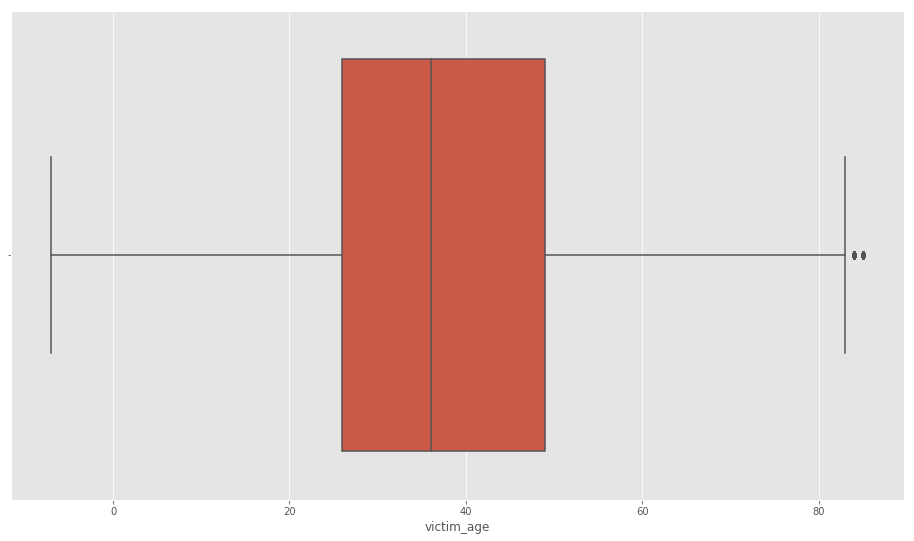

In [26]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df.victim_age)

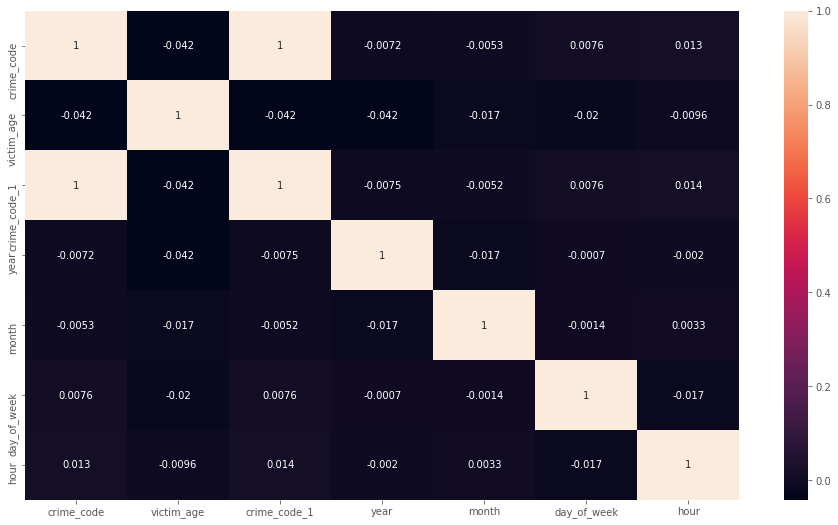

In [39]:
#correlation between the data
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [10]:
#what type of crime is most prevalent?
df.crime_code_description.value_counts(dropna=True)[:5]

BATTERY - SIMPLE ASSAULT              174932
BURGLARY FROM VEHICLE                 148665
VEHICLE - STOLEN                      147517
BURGLARY                              137460
THEFT PLAIN - PETTY ($950 & UNDER)    137145
Name: crime_code_description, dtype: int64

In [48]:
#what type of crime is least prevalent?
df.crime_code_description.value_counts()[-5:]

BLOCKING DOOR INDUCTION CENTER              3
TILL TAP - ATTEMPT                          3
FIREARMS RESTRAINING ORDER (FIREARMS RO)    2
TRAIN WRECKING                              2
DRUNK ROLL - ATTEMPT                        1
Name: crime_code_description, dtype: int64

In [67]:
#where was there most crime?
df.area_name.value_counts().[:5]

77th Street    131722
Southwest      122674
N Hollywood    103320
Pacific        100906
Southeast      100288
Name: area_name, dtype: int64

In [62]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Rampart       80521
West LA       80127
Wilshire      78481
Foothill      72360
Hollenbeck    70000
Name: area_name, dtype: int64

In [154]:
#Where did most murders occured?
df[df.crime_code_description == 'CRIMINAL HOMICIDE'].area_name.value_counts()[:5]

77th Street    406
Southeast      345
Newton         217
Southwest      206
Hollenbeck     149
Name: area_name, dtype: int64

In [232]:
#Where did most Rapes occured?
df[df.crime_code_description == 'RAPE, FORCIBLE'].area_name.value_counts()

77th Street    726
Hollywood      661
Southwest      617
Southeast      571
Central        569
Rampart        497
Mission        434
N Hollywood    434
Pacific        428
Olympic        407
Foothill       379
Topanga        359
Van Nuys       358
Harbor         346
Hollenbeck     345
West Valley    344
Newton         339
Northeast      332
Wilshire       327
West LA        319
Devonshire     319
Name: area_name, dtype: int64

In [234]:
#Where did most robbery occured?
df[df.crime_code_description == 'ROBBERY'].area_name.value_counts()

77th Street    9303
Southeast      7338
Southwest      6725
Newton         6328
Rampart        5076
Olympic        4800
Central        4524
Hollywood      3840
Wilshire       2853
Mission        2843
Hollenbeck     2576
Northeast      2499
Harbor         2334
Pacific        2304
N Hollywood    2176
Van Nuys       1912
West Valley    1882
Topanga        1878
Foothill       1829
Devonshire     1603
West LA        1437
Name: area_name, dtype: int64

In [28]:
#Crime by year
print('Crime by year')
print(df.date_time.dt.year.value_counts())
print()

Crime by year
2017    229665
2018    225813
2016    224510
2015    214735
2010    208775
2012    201117
2011    200399
2014    194940
2013    192152
2019     39336
Name: date_time, dtype: int64



In [162]:
#Crime by day of week
print('Crime by day of week')
print(df.date_time.dt.dayofweek.value_counts().sort_index())
print()

Crime by day of week
0    271685
1    266788
2    270051
3    268350
4    293485
5    274028
6    262138
Name: date_time, dtype: int64



In [29]:
#Crime by day of hour
print('Crime by hour')
print(df.date_time.dt.hour.value_counts()[:5])
print()

Crime by hour
12    153879
18    115464
20    111776
19    109546
17    107502
Name: date_time, dtype: int64



In [165]:
# Top 5 crimes against women
print('Main Crime type against women')
print(df[df['victim_sex'] == 'F' ].crime_code_description.value_counts()[:5])
print()

BATTERY - SIMPLE ASSAULT              74045
INTIMATE PARTNER - SIMPLE ASSAULT     65318
BURGLARY FROM VEHICLE                 51880
THEFT OF IDENTITY                     48256
THEFT PLAIN - PETTY ($950 & UNDER)    47452
Name: crime_code_description, dtype: int64

In [166]:
# Top 5 crimes against men
print('Main Crime type against men')
print(df[df['victim_sex'] == 'M' ].crime_code_description.value_counts()[:5])
print()

Main Crime type against women
BATTERY - SIMPLE ASSAULT              64170
BURGLARY FROM VEHICLE                 62490
BURGLARY                              62083
THEFT PLAIN - PETTY ($950 & UNDER)    58009
THEFT OF IDENTITY                     46877
Name: crime_code_description, dtype: int64



In [172]:
df.date_time.dt.year.value_counts().mean()

190652.5

In [67]:
# Murder Victims by gender
df[df['crime_code_description'] == 'CRIMINAL HOMICIDE' ].victim_sex.value_counts()[:5]

M    1774
F     280
X       1
Name: victim_sex, dtype: int64

In [177]:
# Murder Victims by gender
df[df['crime_code_description'] == 'CRIMINAL HOMICIDE' ].victim_descent.value_counts()[:5]

H    990
B    804
W    179
O     52
A     23
Name: victim_descent, dtype: int64

In [299]:
df[df['crime_code_description'] == 'CRIMINAL HOMICIDE' ].victim_age.value_counts().head()

20.0    88
19.0    81
23.0    77
26.0    73
25.0    73
Name: victim_age, dtype: int64

In [69]:
# Murder Victims by age
df[df['crime_code_description'] == 'CRIMINAL HOMICIDE' ].premise_description.value_counts()[:5]

STREET                                          836
SIDEWALK                                        539
SINGLE FAMILY DWELLING                          240
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    238
PARKING LOT                                     146
Name: premise_description, dtype: int64

In [58]:
#pivot table
df.pivot_table(index='victim_descent',
               columns='victim_sex',
               values='victim_age',
               aggfunc='sum',
              fill_value=0)

victim_sex,-,F,H,M,N,X
victim_descent,,,,,,
AmerIndian/Alaskan,0,6266,0,13767,0,0
Asian Indian,0,676,0,1082,0,0
Black,0,5077478,88,3895812,0,45
Cambodian,0,160,0,266,0,0
Chinese,0,10477,0,10679,0,0
Filipino,47,38395,215,33855,0,23
Guamanian,0,1229,0,578,0,0
Hawaiian,0,1920,0,1889,0,0
Hispanic/Latin,0,8631289,801,8534050,61,192


In [176]:
# Murder Victims by gender
df[df['crime_code_description'] == 'RAPE, FORCIBLE' ].area.value_counts()[:5]

M    1774
F     280
X       1
Name: victim_sex, dtype: int64

# Graphs

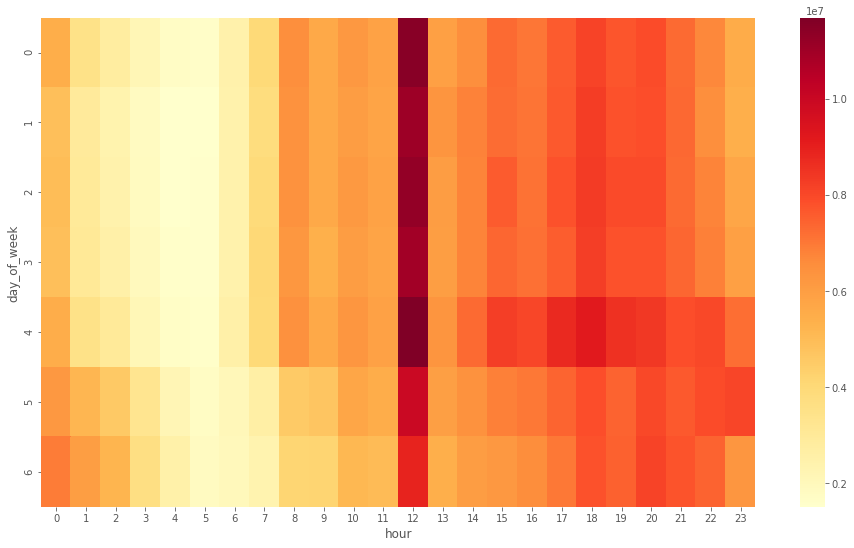

In [5]:
#plot of serious crimes
data = df.groupby(['day_of_week', 'hour']).crime_code_1.sum().unstack()
plt.subplots(figsize=(16,9))         # Sample figsize in inches
sns.heatmap(data, cmap="YlOrRd",)

In [ ]:
#When did most crimes occured in terms of days of the week?
#df.date_time.dt.dayofweek.value_counts().sort_index().plot(figsize=(16,9), kind='bar')
plt.figure(figsize=(16,9))
df.date_time.dt.dayofweek.value_counts().sort_index().plot(kind='bar')

In [307]:
#victims by gender
print(df.victim_sex.value_counts())
print()

#victims by race
print(df.victim_descent.value_counts())
print()

#victims by age
print('victims by avg age')
df.victim_age= df.victim_age.abs()
print(df.victim_age.mean())
print()


M    696957
F    638289
X     20316
H        50
N         1
-         1
Name: victim_sex, dtype: int64

Hispanic/Latin        518692
White                 370335
Black                 241000
Other                 143435
Unknown                36568
Other Asian            34923
Korean                  6810
Filipino                1786
AmerIndian/Alaskan       632
Chinese                  549
Pacific Islander         263
Japanese                 235
Hawaiian                 133
Vietnamese                85
Guamanian                 55
Asian Indian              52
Samoan                    24
Cambodian                 14
Laotian                   11
-                          1
Name: victim_descent, dtype: int64

victims by avg age
39.14846755352459



In [317]:
df.victim_age.value_counts()


AttributeError: 'DataFrame' object has no attribute 'victim_age'

In [31]:
#victims by gender and crime
print('Main crime incidents on Women')
print(df[df['victim_sex'] == 'F'].crime_code_description.value_counts()[:5])
print()
print('Main crime incidents on Men')
print(df[df['victim_sex'] == 'M'].crime_code_description.value_counts()[:5])
print()



Main crime incidents on Women
BATTERY - SIMPLE ASSAULT              74045
INTIMATE PARTNER - SIMPLE ASSAULT     65318
BURGLARY FROM VEHICLE                 51880
THEFT OF IDENTITY                     48256
THEFT PLAIN - PETTY ($950 & UNDER)    47452
Name: crime_code_description, dtype: int64

Main crime incidents on Men
BATTERY - SIMPLE ASSAULT              64170
BURGLARY FROM VEHICLE                 62490
BURGLARY                              62083
THEFT PLAIN - PETTY ($950 & UNDER)    58009
THEFT OF IDENTITY                     46877
Name: crime_code_description, dtype: int64

Main crime incidents on victims over 80 years old
VEHICLE - STOLEN                                   144709
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)     41875
BATTERY - SIMPLE ASSAULT                            37722
BURGLARY                                            37492
THEFT PLAIN - PETTY ($950 & UNDER)                  34739
Name: crime_code_description, dtype: int64


Main crime incidents on Korean women between 20 and 30 years old in 2018


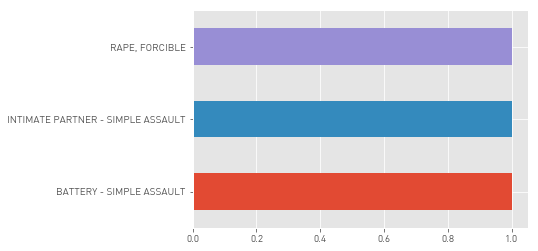

In [27]:
print('Main crime incidents on Korean women between 20 and 30 years old in 2018')
df[(df['victim_age'] >= 20)   
 & (df['victim_age'] <= 30) 
 & (df['victim_sex'] == 'F')
 & (df['victim_descent'] == 'Korean')
 & (df['year'] == 2018)].crime_code_description.value_counts().plot(kind='barh')


Main crime incidents on Japanese women between 20 and 40 years old in 2018


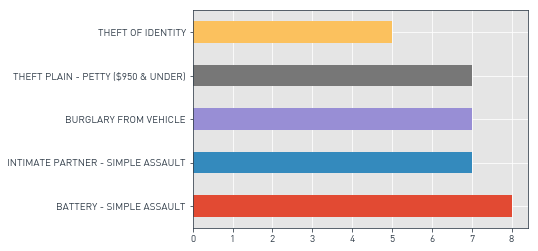

In [55]:
print('Main crime incidents on Japanese women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['victim_sex'] == 'F')
 & (df['victim_descent'] == 'Japanese')].crime_code_description.value_counts()[:5].plot(kind='barh')


In [117]:
print('Main crime incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['victim_sex'] == 'F')
 & (df['victim_descent'] == 'White')].crime_code_description.value_counts()[:5]


Main crime incidents on White women between 20 and 40 years old in 2018


Rape incidents on White women between 20 and 40 years old in 2018


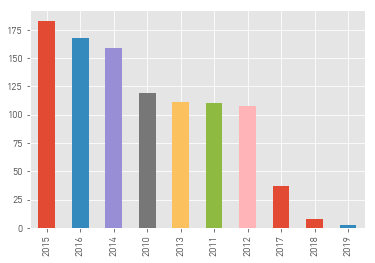

In [29]:
print('Rape incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['victim_sex'] == 'F')
 & (df['victim_descent'] == 'White')
 & (df['crime_code_description'] == 'RAPE, FORCIBLE')].year.value_counts().plot(kind='bar')

Main crime incidents on Black women between 20 and 40 years old in 2018


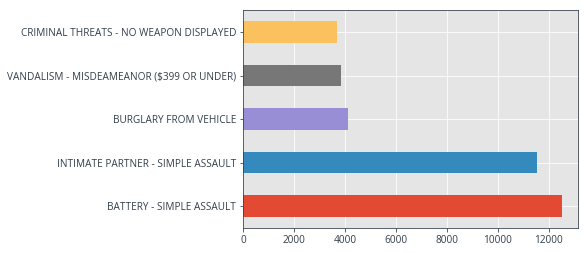

In [61]:
print('Main crime incidents on Black women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['victim_sex'] == 'F')
 & (df['victim_descent'] == 'Black')].crime_code_description.value_counts()[:5].plot(kind='barh')


In [56]:
print('Main crime incidents on victims over 60 years old')
df[(df['victim_age'] < 60)].crime_code_description.value_counts()[:5]


Main crime incidents on victims over 60 years old


BATTERY - SIMPLE ASSAULT              127241
BURGLARY FROM VEHICLE                 105697
THEFT PLAIN - PETTY ($950 & UNDER)     92740
BURGLARY                               86491
INTIMATE PARTNER - SIMPLE ASSAULT      78932
Name: crime_code_description, dtype: int64

# Map

In [57]:
iterable(folium.CircleMarker)

TypeError: 'type' object is not iterable

In [48]:
#map of crime in LA

m = folium.Map(
    location=[34.127141, -118.29008],
    zoom_start=13,
    tiles='StamenToner'
)

mc = folium.plugins.MarkerCluster().add_to(m)


for row in range(len(df_northeast_2019)):
    date = str(df_northeast_2019.date_occurred[row])
    time = str(df_northeast_2019.time_occurred[row])
    crime_code = df_northeast_2019.crime_code_description[row]
    victim_race = str(df_northeast_2019.victim_descent[row])
    victim_age = str(df_northeast_2019.victim_age[row])
    victim_sex = str(df_northeast_2019.victim_sex[row])
    status = str(df_northeast_2019.status_description[row])
    popup = 'Date: ' + date + ' Time: ' + time + ' Crime: ' + crime_code + \
    ' Victim Race: ' + victim_race + ' Victim Age: ' + victim_age + ' Victim Gender: ' + victim_sex + ' Status: ' + status
    folium.CircleMarker(df_northeast_2019.location_[row],
                        radius=20,
                        stroke=False,
                       popup = popup,   
                        fill_color='red',
                       fill_opacity=0.4,
                       ).add_to(mc)

'''
popup_string = str(df.date_time) + " " + df.crime_code_description
folium.CircleMarker(location=[df.location[0:100]], number_of_sides=4, popup=popup_string, radius=6).add_to(mc)
'''


folium.plugins.Fullscreen(position='bottomright').add_to(m)

#folium.map.LayerControl().add_to(m)
            
#m.save('/Users/nonoumasy/Desktop/crime_map.html')
m.save('/Users/nonoumasy/Desktop/northeast.html')
m

#sends an sms once this cell finishes executing
#os.system('python send_sms.py')

#map of LAPD Divisional Map.
some text

![Image](http://www.lapdwilshire.com/uploads/3/0/7/1/30711601/6222770.jpg?816)

# Insights

In [22]:
#Is crime increasing or decreasing in time?
df.datetime_series.dt.year.value_counts().sort_index()[0:9]

2010    208753
2011    200384
2012    201094
2013    192128
2014    194903
2015    214686
2016    224445
2017    229531
2018    224745
Name: datetime_series, dtype: int64

Text(0.5, 1.0, 'Is Crime going up or down in the city of Angels?')

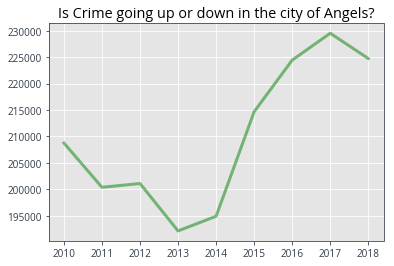

In [71]:
#Is crime increasing or decreasing in time? Show
trend = df.date_time.dt.year.value_counts().sort_index()[0:9]
plt.plot(trend, alpha=0.5, color='g' , linewidth=3, )
#plt.axhline(y=0)
plt.title('Is Crime going up or down in the city of Angels?')

AxesSubplot(0.125,0.125;0.775x0.755)



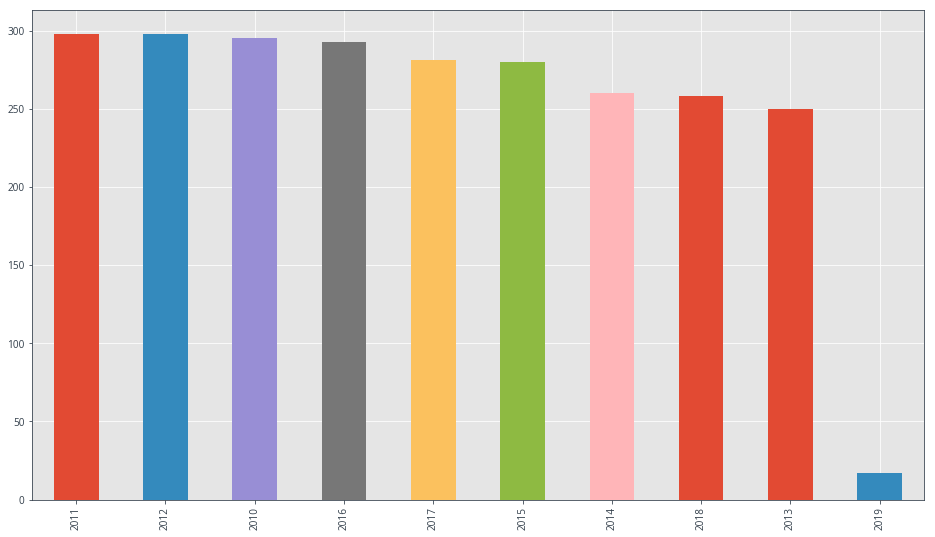

In [225]:
#murder by year
print(df[df['crime_code_description'] == 'CRIMINAL HOMICIDE' ].year.value_counts().plot(figsize=(16,9), kind='bar'))
print()

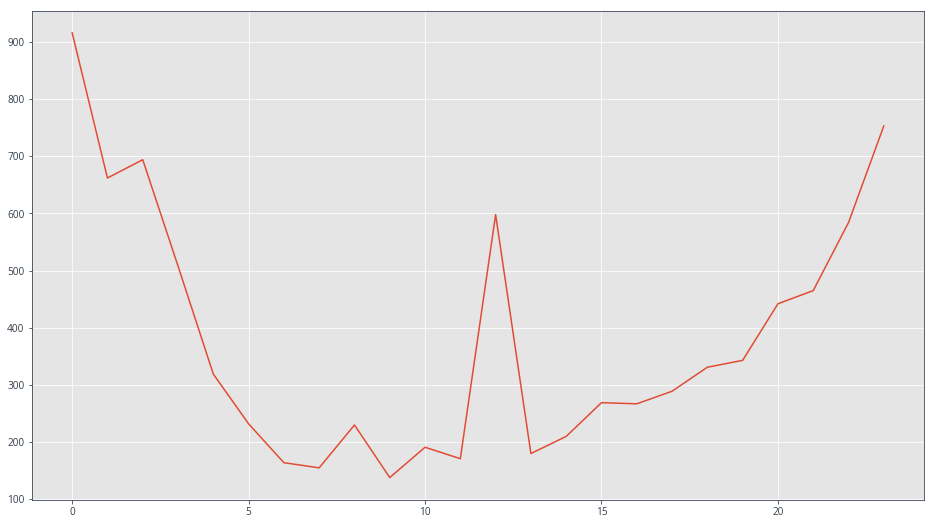

In [219]:
# When does most Rape occur?
df[df['crime_code_description'] == 'RAPE, FORCIBLE' ].date_time.dt.hour.value_counts().sort_index().plot(figsize=(16,9))


In [208]:
fig, ax = plt.subplots(figsize=(16,9))
sns.scatterplot(df.victim_year, df.victim_age, legend='full', ax=ax, sizes=)


SyntaxError: invalid syntax (<ipython-input-208-36cd79b359a0>, line 2)

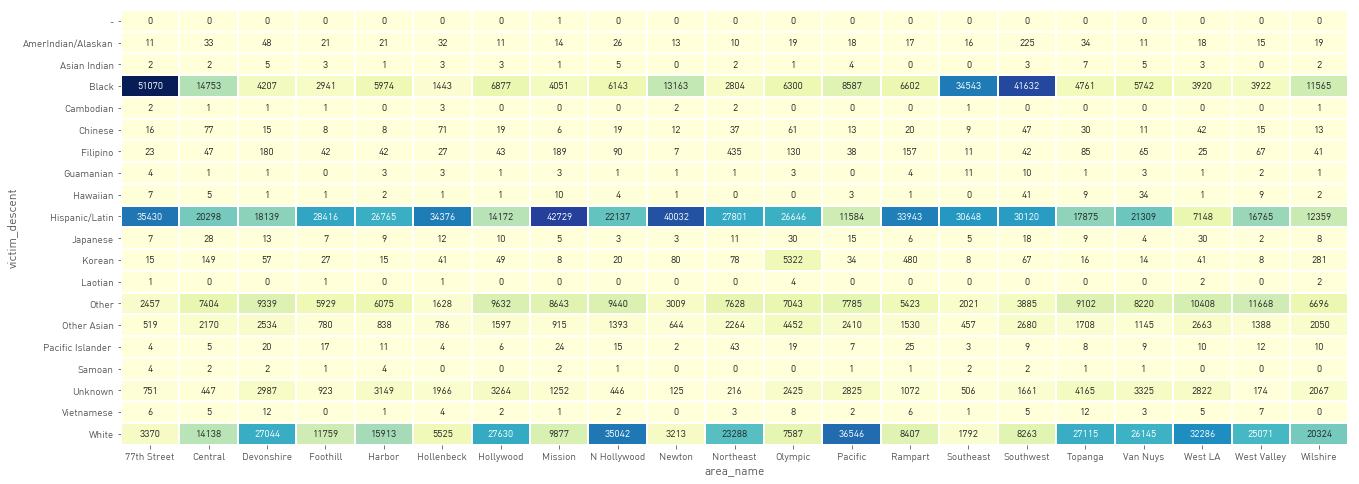

In [50]:
cross_tab = pd.crosstab(df.victim_descent, df.area_name)
fig, ax = plt.subplots(figsize=(22,8))         # Sample figsize in inches
sns.heatmap(cross_tab,
            cmap="YlGnBu",
            annot=True,
            fmt="d",
            linewidths=1,
            cbar=False,
            ax=ax)

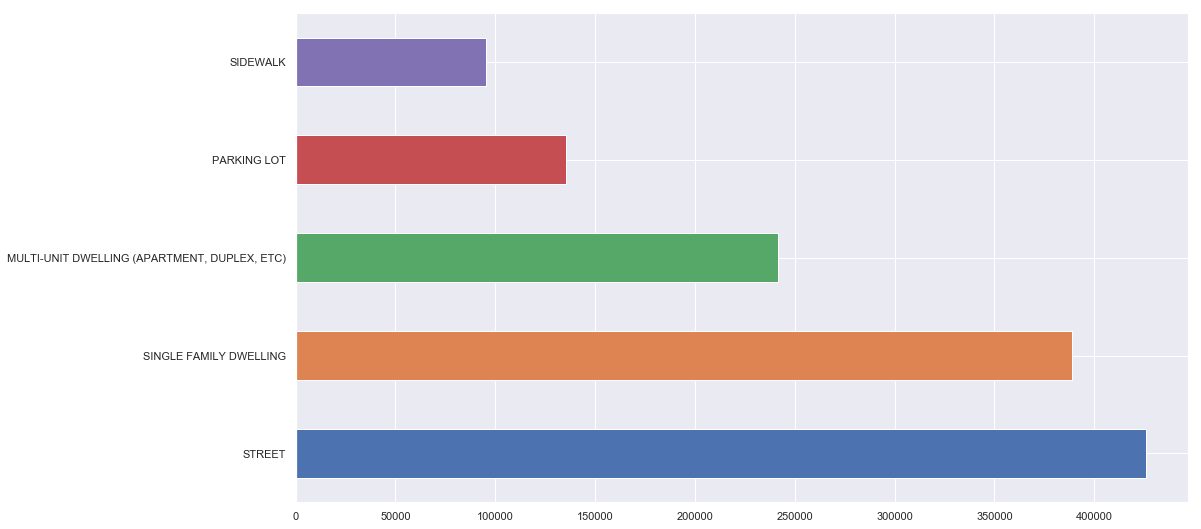

In [300]:
#where did crime incidents occur?
df.premise_description.value_counts()[:5].plot(kind='barh', figsize=(16,9))

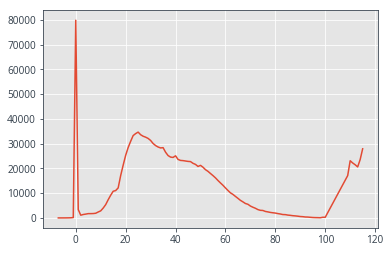

In [228]:
#victim by age
df.victim_age.value_counts().sort_index().plot()

# Resolution

# References:
*LAPD Crime 
    http://www.lapdonline.org/inside_the_lapd/content_basic_view/27333
    
*Crime Classification Grouping:
    https://www.nap.edu/read/23492/chapter/7#128